In [ ]:
import geopandas as gpd
import rasterio
from rasterio.transform import from_origin
import numpy as np
from joblib import load
from rasterio.features import geometry_mask

# Step 1: Read MSG LST data from the .gpkg file
msg_data = "../msg_lu_fused_data_for_glm/concatenated_data.gpkg"
gdf = gpd.read_file(msg_data)

# Step 2: Filter by year, month, day, and hour
year = 2023
month = 7
day = 18
hour = 13

filtered_gdf = gdf[
    (gdf['year'] == year) &
    (gdf['month'] == month) &
    (gdf['day'] == day) &
    (gdf['hour'] == hour)
]

# Check if any data is available after filtering
if filtered_gdf.empty:
    print("No data found for the specified date and time.")
    exit()

print(f"Filtered data count: {len(filtered_gdf)}")

# Step 3: Extract coordinates and LST values
x_coords = filtered_gdf.geometry.x
y_coords = filtered_gdf.geometry.y
lst_values = filtered_gdf['temperature']

# Step 4: Define the raster resolution and extent
min_x, min_y, max_x, max_y = filtered_gdf.total_bounds
resolution = 0.05  # Set resolution to 0.05 degrees
cols = int((max_x - min_x) / resolution) + 1
rows = int((max_y - min_y) / resolution) + 1

# Create an empty array for the raster
raster = np.full((rows, cols), -9999, dtype=np.float32)  # Set -9999 as nodata
transform = from_origin(min_x, max_y, resolution, resolution)

for x, y, val in zip(x_coords, y_coords, lst_values):
    col = int((x - min_x) / resolution)
    row = int((max_y - y) / resolution)
    if 0 <= col < cols and 0 <= row < rows:
        raster[row, col] = val

# Step 5: Save the raster with a dynamically formatted file name
output_raster = f"../lst_rasters/MSG-LST-{year}-{month:02d}-{day:02d}-{hour:02d}.tif"

with rasterio.open(
    output_raster,
    'w',
    driver='GTiff',
    height=rows,
    width=cols,
    count=1,
    dtype=raster.dtype,
    crs=filtered_gdf.crs,
    transform=transform,
    nodata=-9999
) as dst:
    dst.write(raster, 1)

print(f"Raster file saved as: {output_raster}")


In [ ]:
output_raster

In [ ]:

# Step 6: Load the trained model
model_filename = "random_forest_model.pkl"
loaded_model = load(model_filename)

# Step 7: Load land use profiles for the geometry points in the LU profile file
lu_profile_file = "../lu_profiles/rome_2023_landuse_profile_35m.gpkg"
lu_gdf = gpd.read_file(lu_profile_file)

print(lu_gdf.shape)

# Step 4: Define the raster resolution and extent
min_x, min_y, max_x, max_y = lu_gdf.total_bounds
resolution = 0.0006309  # Approximately 70 meters in degrees at 42°N
cols = int((max_x - min_x) / resolution) + 1
rows = int((max_y - min_y) / resolution) + 1

print(f'{rows}, {cols}')

In [ ]:

# Step 8: Get the MSG LST temperature for the points from the raster file
with rasterio.open(output_raster) as src:
    coords = [(point.x, point.y) for point in lu_gdf.geometry]
    print(len(coords))
    lu_gdf['msg_lst_temperature'] = [
        val[0] if val else -9999
        for val in rasterio.sample.sample_gen(src, coords)
    ]

In [ ]:

# Initialize to nodata
lu_gdf['predicted_temperature'] = -9999

# Step 9: Drop rows with nodata in `msg_lst_temperature`
lu_gdf_filtered = lu_gdf[lu_gdf['msg_lst_temperature'] != -9999].copy()  # Explicit copy to avoid warning

# Step 10: Convert temperature to Kelvin
lu_gdf_filtered.loc[:, 'msg_lst_temperature'] += 273.15  # Use .loc for modifying values

# Step 11: Add month and hour predictor values
lu_gdf_filtered.loc[:, 'month'] = month
lu_gdf_filtered.loc[:, 'hour'] = hour

# Step 12: Drop rows where all land-use predictors are `0`
predictors = ['trees', 'water', 'crop', 'built_area', 'range_land', 'msg_lst_temperature', 'month', 'hour']
lu_gdf_filtered = lu_gdf_filtered[(lu_gdf_filtered[predictors[:-2]] != 0).any(axis=1)].copy()  # Explicit copy

# Step 13: Predict LST temperatures for the filtered LU profiles using the model
lu_gdf_filtered['predicted_temperature'] = loaded_model.predict(lu_gdf_filtered[predictors])

# Step 14: Update the original GeoDataFrame with predictions
lu_gdf.loc[lu_gdf_filtered.index, 'predicted_temperature'] = lu_gdf_filtered['predicted_temperature']

# Step 15: Convert predicted temperatures to Celsius (only for non-nodata values)
lu_gdf.loc[lu_gdf['predicted_temperature'] != -9999, 'predicted_temperature'] -= 273.15

# Step 17: Create raster of the predicted LST
predicted_raster = np.full((rows, cols), -9999, dtype=np.float32)

for idx, row in lu_gdf.iterrows():
    x, y, temp = row.geometry.x, row.geometry.y, row['predicted_temperature']
    col = int((x - min_x) / resolution)
    row = int((max_y - y) / resolution)
    if 0 <= col < cols and 0 <= row < rows:
        predicted_raster[row, col] = temp

# Step 18: Save the predicted raster
output_predicted_raster = f"../lst_rasters/MSG-LST-DOWNSCALED-{year}-{month:02d}-{day:02d}-{hour:02d}.tif"
transform = from_origin(min_x, max_y, resolution, resolution)

with rasterio.open(
    output_predicted_raster,
    'w',
    driver='GTiff',
    height=rows,
    width=cols,
    count=1,
    dtype=predicted_raster.dtype,
    crs=lu_gdf.crs,
    transform=transform,
    nodata=-9999
) as dst:
    dst.write(predicted_raster, 1)

print(f"Predicted raster file saved as: {output_predicted_raster}")


In [ ]:
print(f'{rows}, {cols}')

In [ ]:
import rasterio
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import ListedColormap, BoundaryNorm

# Load the raster file
raster_file = output_predicted_raster  # Replace with your raster file path
with rasterio.open(raster_file) as src:
    raster_data = src.read(1)  # Read the first band
    transform = src.transform

# Convert -9999 (nodata) to NaN for easier handling
raster_data = np.where(raster_data == -9999, np.nan, raster_data)

# Define the bounding box for subsetting
min_lon, max_lon = 12.40, 12.60
max_lat = 41.85

# Calculate row and column indices for the bounding box
min_col = int((min_lon - transform[2]) / transform[0])
max_col = int((max_lon - transform[2]) / transform[0])
min_row = int((max_lat - transform[5]) / transform[4])
max_row = raster_data.shape[0]  # Plot all rows below max_lat

# Subset the raster data
subset_data = raster_data[min_row:max_row, min_col:max_col]

# Update extent for the subset
subset_transform = transform * rasterio.Affine.translation(min_col, min_row)
extent = (
    subset_transform[2],  # min X (lon)
    subset_transform[2] + subset_transform[0] * subset_data.shape[1],  # max X (lon)
    subset_transform[5] + subset_transform[4] * subset_data.shape[0],  # min Y (lat)
    subset_transform[5],  # max Y (lat)
)

# Define temperature bins (1 degree Celsius each)
temp_min = np.nanmin(subset_data)  # Minimum temperature in the subset
temp_max = np.nanmax(subset_data)  # Maximum temperature in the subset
bins = np.arange(np.floor(temp_min), np.ceil(temp_max) + 1, 1)  # 1-degree bins

# Create a color map for the bins
cmap = ListedColormap(plt.cm.viridis(np.linspace(0, 1, len(bins) - 1)))
norm = BoundaryNorm(bins, cmap.N)

# Plot the raster subset
plt.figure(figsize=(10, 8))
plt.imshow(subset_data, cmap=cmap, norm=norm, extent=extent, interpolation='nearest')
plt.colorbar(label="Temperature (°C)", ticks=bins)
plt.title("LST Raster Subset (12.40 to 12.60 Lon, Below 41.85 Lat)")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()


In [ ]:
import rasterio
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import ListedColormap, BoundaryNorm

# Load the raster file
raster_file = output_raster  # Replace with your raster file path
with rasterio.open(raster_file) as src:
    raster_data = src.read(1)  # Read the first band
    transform = src.transform

# Convert -9999 (nodata) to NaN for easier handling
raster_data = np.where(raster_data == -9999, np.nan, raster_data)

# Define the bounding box for subsetting
min_lon, max_lon = 12.40, 12.60
max_lat = 41.85

# Calculate row and column indices for the bounding box
min_col = int((min_lon - transform[2]) / transform[0])
max_col = int((max_lon - transform[2]) / transform[0])
min_row = int((max_lat - transform[5]) / transform[4])
max_row = raster_data.shape[0]  # Plot all rows below max_lat

# Subset the raster data
subset_data = raster_data[min_row:max_row, min_col:max_col]

# Update extent for the subset
subset_transform = transform * rasterio.Affine.translation(min_col, min_row)
extent = (
    subset_transform[2],  # min X (lon)
    subset_transform[2] + subset_transform[0] * subset_data.shape[1],  # max X (lon)
    subset_transform[5] + subset_transform[4] * subset_data.shape[0],  # min Y (lat)
    subset_transform[5],  # max Y (lat)
)

# Define temperature bins (1 degree Celsius each)
temp_min = np.nanmin(subset_data)  # Minimum temperature in the subset
temp_max = np.nanmax(subset_data)  # Maximum temperature in the subset
bins = np.arange(np.floor(temp_min), np.ceil(temp_max) + 1, 1)  # 1-degree bins

# Create a color map for the bins
cmap = ListedColormap(plt.cm.viridis(np.linspace(0, 1, len(bins) - 1)))
norm = BoundaryNorm(bins, cmap.N)

# Plot the raster subset
plt.figure(figsize=(10, 8))
plt.imshow(subset_data, cmap=cmap, norm=norm, extent=extent, interpolation='nearest')
plt.colorbar(label="Temperature (°C)", ticks=bins)
plt.title("LST Raster Subset (12.40 to 12.60 Lon, Below 41.85 Lat)")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()


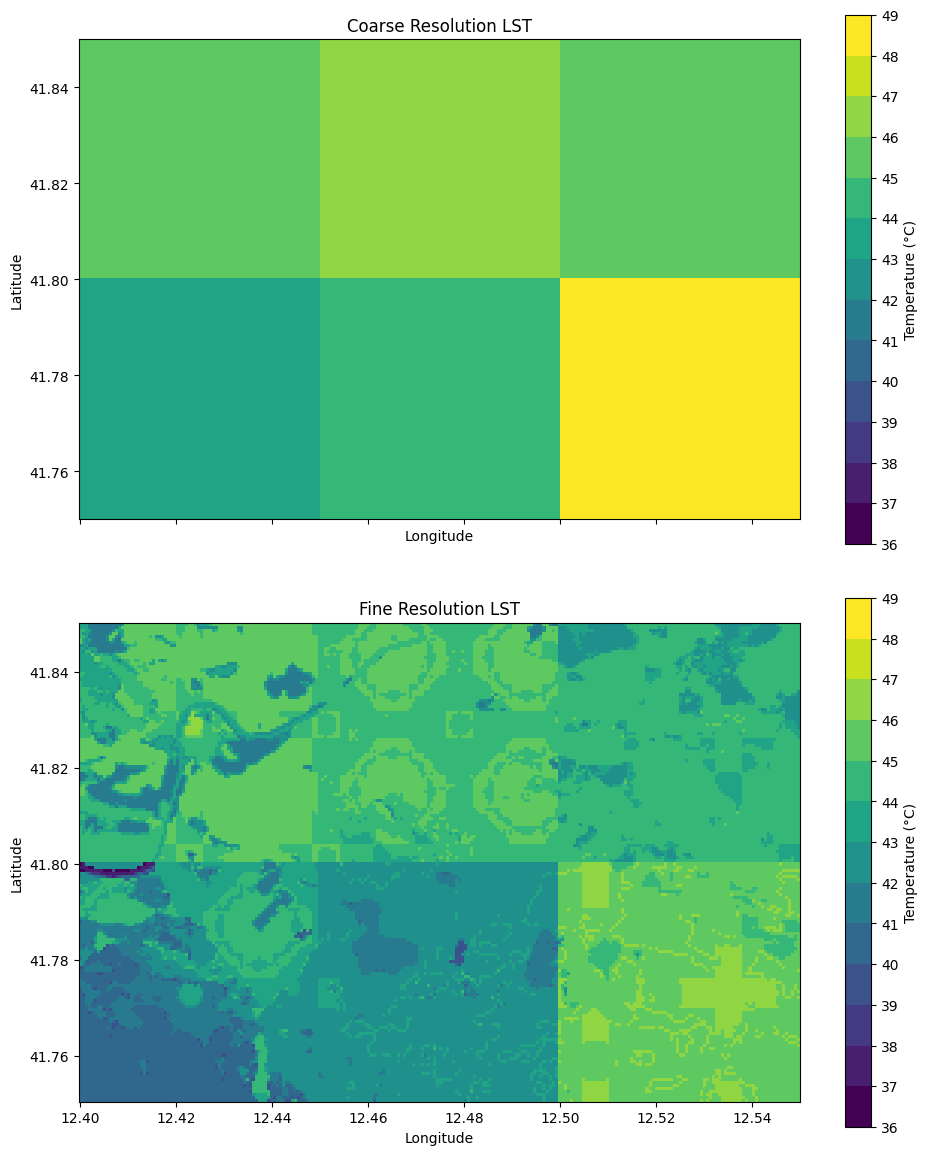

In [50]:
import rasterio
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import ListedColormap, BoundaryNorm

# Load the coarse and fine resolution raster files
coarse_raster_file = output_raster  # Replace with your coarse raster file path
fine_raster_file = output_predicted_raster      # Replace with your fine raster file path

# Define the extent (bounding box) to extract (in geographic coordinates)
min_lon, max_lon = 12.40, 12.550
min_lat, max_lat = 41.75, 41.85  # Adjust as needed

# Helper function to extract data within bounds
def extract_raster_data(raster_file, min_lon, max_lon, min_lat, max_lat):
    with rasterio.open(raster_file) as src:
        transform = src.transform
        raster_data = src.read(1)  # Read the first band
        raster_data = np.where(raster_data == src.nodata, np.nan, raster_data)  # Replace nodata with NaN

        # Calculate row/col indices for the bounding box
        min_col = int((min_lon - transform[2]) / transform[0])
        max_col = int((max_lon - transform[2]) / transform[0])
        min_row = int((max_lat - transform[5]) / transform[4])
        max_row = int((min_lat - transform[5]) / transform[4])

        # Subset the raster data
        subset_data = raster_data[min_row:max_row, min_col:max_col]
        extent = (
            transform[2] + min_col * transform[0],  # min X (lon)
            transform[2] + max_col * transform[0],  # max X (lon)
            transform[5] + max_row * transform[4],  # min Y (lat)
            transform[5] + min_row * transform[4],  # max Y (lat)
        )
        return subset_data, extent

# Extract the subset for the coarse raster
coarse_data, coarse_extent = extract_raster_data(coarse_raster_file, min_lon, max_lon, min_lat, max_lat)

# Extract the subset for the fine raster
fine_data, fine_extent = extract_raster_data(fine_raster_file, min_lon, max_lon, min_lat, max_lat)

# Define temperature bins (1 degree Celsius each)
temp_min = min(np.nanmin(coarse_data), np.nanmin(fine_data))
temp_max = max(np.nanmax(coarse_data), np.nanmax(fine_data))
bins = np.arange(np.floor(temp_min), np.ceil(temp_max) + 1, 1)  # 1-degree bins

# Create a color map for the bins
cmap = ListedColormap(plt.cm.viridis(np.linspace(0, 1, len(bins) - 1)))
norm = BoundaryNorm(bins, cmap.N)

# Plot the rasters
fig, axes = plt.subplots(2, 1, figsize=(10, 12), sharex=True)

# Plot the coarse raster
ax = axes[0]
im = ax.imshow(coarse_data, cmap=cmap, norm=norm, extent=coarse_extent, interpolation='nearest')
ax.set_title("Coarse Resolution LST")
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
plt.colorbar(im, ax=ax, label="Temperature (°C)", ticks=bins)

# Plot the fine raster
ax = axes[1]
im = ax.imshow(fine_data, cmap=cmap, norm=norm, extent=fine_extent, interpolation='nearest')
ax.set_title("Fine Resolution LST")
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
plt.colorbar(im, ax=ax, label="Temperature (°C)", ticks=bins)

plt.tight_layout()
plt.show()
